In [1]:
!pip install pyspark

In [2]:
!pip install py4j

In [3]:
!pip install findspark

In [4]:
import findspark
findspark.init()

In [5]:
from pyspark.sql import SparkSession

In [6]:
spark = SparkSession.builder \
    .appName("Processing Big Data") \
    .config("spark.executor.memory", "8g") \
    .config("spark.driver.memory", "8g") \
    .getOrCreate()

In [7]:
# Define the file paths
path = "C:\\Users\\anxhe\\OneDrive\\Desktop\\PBD_Dataset\\" 

# Load datasets into DataFrames
dim_customer = spark.read.csv(path + "DimCustomer.csv", header=True, inferSchema=True)
dim_product = spark.read.csv(path + "DimProduct.csv", header=True, inferSchema=True)
dim_sales_territory = spark.read.csv(path + "DimSalesTerritory.csv", header=True, inferSchema=True)
fact_internet_sales = spark.read.csv(path + "FactInternetSales.csv", header=True, inferSchema=True)

dim_customer.printSchema()
dim_product.printSchema()
dim_sales_territory.printSchema()
fact_internet_sales.printSchema()

root
 |-- CustomerKey: integer (nullable = true)
 |-- GeographyKey: integer (nullable = true)
 |-- CustomerAlternateKey: string (nullable = true)
 |-- Title: string (nullable = true)
 |-- FirstName: string (nullable = true)
 |-- MiddleName: string (nullable = true)
 |-- LastName: string (nullable = true)
 |-- NameStyle: boolean (nullable = true)
 |-- BirthDate: date (nullable = true)
 |-- MaritalStatus: string (nullable = true)
 |-- Suffix: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- EmailAddress: string (nullable = true)
 |-- YearlyIncome: integer (nullable = true)
 |-- TotalChildren: integer (nullable = true)
 |-- NumberChildrenAtHome: integer (nullable = true)
 |-- EnglishEducation: string (nullable = true)
 |-- SpanishEducation: string (nullable = true)
 |-- FrenchEducation: string (nullable = true)
 |-- EnglishOccupation: string (nullable = true)
 |-- SpanishOccupation: string (nullable = true)
 |-- FrenchOccupation: string (nullable = true)
 |-- HouseOwner

In [8]:
# Load datasets with selected columns
dim_customer = dim_customer.select("CustomerKey", "BirthDate", "Gender", "MaritalStatus", "NumberCarsOwned", "HouseOwnerFlag", "EnglishEducation","TotalChildren", "YearlyIncome", "CommuteDistance","EnglishOccupation")

dim_product = dim_product.select("ProductKey","ProductSubcategoryKey", "StandardCost", "ListPrice", "ReorderPoint")

dim_sales_territory = dim_sales_territory.select("SalesTerritoryKey", "SalesTerritoryCountry")

fact_internet_sales = fact_internet_sales.select("ProductKey", "CustomerKey", "SalesTerritoryKey", "UnitPrice", "SalesAmount","TotalProductCost", )

In [9]:
dim_customer.show(5)
dim_product.show(5)
dim_sales_territory.show(5)
fact_internet_sales.show(5)

+-----------+----------+------+-------------+---------------+--------------+----------------+-------------+------------+---------------+-----------------+
|CustomerKey| BirthDate|Gender|MaritalStatus|NumberCarsOwned|HouseOwnerFlag|EnglishEducation|TotalChildren|YearlyIncome|CommuteDistance|EnglishOccupation|
+-----------+----------+------+-------------+---------------+--------------+----------------+-------------+------------+---------------+-----------------+
|      11000|1966-04-08|     M|            M|              0|             1|       Bachelors|            2|       90000|      1-2 Miles|     Professional|
|      11001|1965-05-14|     M|            S|              1|             0|       Bachelors|            3|       60000|      0-1 Miles|     Professional|
|      11002|1965-08-12|     M|            M|              1|             1|       Bachelors|            3|       60000|      2-5 Miles|     Professional|
|      11003|1968-02-15|     F|            S|              1|         

In [10]:
from pyspark.sql.functions import col, mean

# Handling missing values for DimCustomer
dim_customer = dim_customer.fillna({
    "YearlyIncome": dim_customer.agg(mean("YearlyIncome")).collect()[0][0], 
    "Gender": "Unknown", 
    "MaritalStatus": "Unknown",
})

# Remove rows with NULL values
dim_product = dim_product.na.drop()

# Handling missing values for DimSalesTerritory
dim_sales_territory = dim_sales_territory.fillna({
    "SalesTerritoryCountry": "Unknown"
})

# Fill missing values in 'FactInternetSales'
fact_internet_sales = fact_internet_sales.fillna({ 
    "UnitPrice": fact_internet_sales.agg(mean("UnitPrice")).collect()[0][0],
    "SalesAmount": fact_internet_sales.agg(mean("SalesAmount")).collect()[0][0],
})

In [11]:
from pyspark.sql import functions as F

# Check for missing values in each column for DimCustomer (and similarly for other DataFrames)
dim_customer_nulls = dim_customer.select([F.sum(F.col(c).isNull().cast("int")).alias(c) for c in dim_customer.columns])
dim_product_nulls = dim_product.select([F.sum(F.col(c).isNull().cast("int")).alias(c) for c in dim_product.columns])
dim_sales_territory_nulls = dim_sales_territory.select([F.sum(F.col(c).isNull().cast("int")).alias(c) for c in dim_sales_territory.columns])
fact_internet_sales_nulls = fact_internet_sales.select([F.sum(F.col(c).isNull().cast("int")).alias(c) for c in fact_internet_sales.columns])

# Show the results
dim_customer_nulls.show()
dim_product_nulls.show()
dim_sales_territory_nulls.show()
fact_internet_sales_nulls.show()

+-----------+---------+------+-------------+---------------+--------------+----------------+-------------+------------+---------------+-----------------+
|CustomerKey|BirthDate|Gender|MaritalStatus|NumberCarsOwned|HouseOwnerFlag|EnglishEducation|TotalChildren|YearlyIncome|CommuteDistance|EnglishOccupation|
+-----------+---------+------+-------------+---------------+--------------+----------------+-------------+------------+---------------+-----------------+
|          0|        0|     0|            0|              0|             0|               0|            0|           0|              0|                0|
+-----------+---------+------+-------------+---------------+--------------+----------------+-------------+------------+---------------+-----------------+

+----------+---------------------+------------+---------+------------+
|ProductKey|ProductSubcategoryKey|StandardCost|ListPrice|ReorderPoint|
+----------+---------------------+------------+---------+------------+
|         0|    

In [12]:
# Perform inner join and drop the duplicate ProductKey from dim_product_cleaned
fact_product_sales = fact_internet_sales.join(dim_product, "ProductKey", "inner") \
                                        .drop(dim_product["ProductKey"])
# Perform inner join with dim_customer
fact_customer_product_sales = fact_product_sales.join(dim_customer, "CustomerKey", "inner") \
                                        .drop(dim_customer["CustomerKey"])
# Perform inner join with dim_sales_territory
fact_complete_sales = fact_customer_product_sales.join(dim_sales_territory, "SalesTerritoryKey", "inner") \
                                                 .drop(dim_sales_territory["SalesTerritoryKey"])

# Show the result
fact_complete_sales.show(5)

+-----------------+-----------+----------+---------+-----------+----------------+---------------------+------------+---------+------------+----------+------+-------------+---------------+--------------+----------------+-------------+------------+---------------+-----------------+---------------------+
|SalesTerritoryKey|CustomerKey|ProductKey|UnitPrice|SalesAmount|TotalProductCost|ProductSubcategoryKey|StandardCost|ListPrice|ReorderPoint| BirthDate|Gender|MaritalStatus|NumberCarsOwned|HouseOwnerFlag|EnglishEducation|TotalChildren|YearlyIncome|CommuteDistance|EnglishOccupation|SalesTerritoryCountry|
+-----------------+-----------+----------+---------+-----------+----------------+---------------------+------------+---------+------------+----------+------+-------------+---------------+--------------+----------------+-------------+------------+---------------+-----------------+---------------------+
|                6|      21768|       310|  3578.27|    3578.27|       2171.2942|          

In [13]:
from pyspark.sql.functions import current_date, year, col, to_date

# Convert BirthDate to date (if it's a string)
fact_complete_sales = fact_complete_sales.withColumn("BirthDate", to_date(col("BirthDate"), "yyyy-MM-dd"))

# Calculate Age based on the difference between the current year and the year of BirthDate
fact_complete_sales = fact_complete_sales.withColumn("Age", year(current_date()) - year(col("BirthDate")))

fact_complete_sales.printSchema()

root
 |-- SalesTerritoryKey: integer (nullable = true)
 |-- CustomerKey: integer (nullable = true)
 |-- ProductKey: integer (nullable = true)
 |-- UnitPrice: double (nullable = false)
 |-- SalesAmount: double (nullable = false)
 |-- TotalProductCost: double (nullable = true)
 |-- ProductSubcategoryKey: integer (nullable = true)
 |-- StandardCost: double (nullable = true)
 |-- ListPrice: double (nullable = true)
 |-- ReorderPoint: integer (nullable = true)
 |-- BirthDate: date (nullable = true)
 |-- Gender: string (nullable = false)
 |-- MaritalStatus: string (nullable = false)
 |-- NumberCarsOwned: integer (nullable = true)
 |-- HouseOwnerFlag: integer (nullable = true)
 |-- EnglishEducation: string (nullable = true)
 |-- TotalChildren: integer (nullable = true)
 |-- YearlyIncome: integer (nullable = true)
 |-- CommuteDistance: string (nullable = true)
 |-- EnglishOccupation: string (nullable = true)
 |-- SalesTerritoryCountry: string (nullable = false)
 |-- Age: integer (nullable = tr

In [14]:
fact_complete_sales_visual = fact_complete_sales

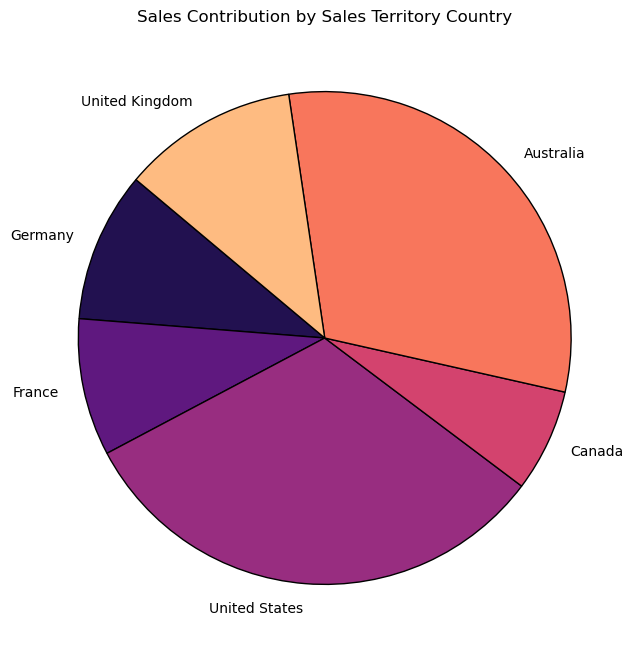

In [15]:
from pyspark.sql import functions as F
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Group by SalesTerritoryCountry and sum SalesAmount
territory_sales = fact_complete_sales_visual.groupBy("SalesTerritoryCountry") \
                                     .agg(F.sum("SalesAmount").alias("TotalSalesAmount")) \
                                        .toPandas()
# Pie Chart with SalesTerritoryCountry as Labels
plt.figure(figsize=(8, 8))
colors = sns.color_palette('magma', len(territory_sales))
plt.pie(territory_sales["TotalSalesAmount"],  # Use SalesAmount for wedge sizes
        labels=territory_sales["SalesTerritoryCountry"],  # Country names as labels
        startangle=140, 
        colors=colors, 
        wedgeprops={'edgecolor': 'black'})

plt.title("Sales Contribution by Sales Territory Country")
plt.show()


C:\Users\anxhe\AppData\Local\Temp\ipykernel_26108\805006322.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_group_sales = fact_complete_sales_pd.groupby("AgeGroup")["SalesAmount"].sum().reset_index()
C:\Users\anxhe\AppData\Local\Temp\ipykernel_26108\805006322.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="AgeGroup", y="SalesAmount", data=age_group_sales, palette="coolwarm")


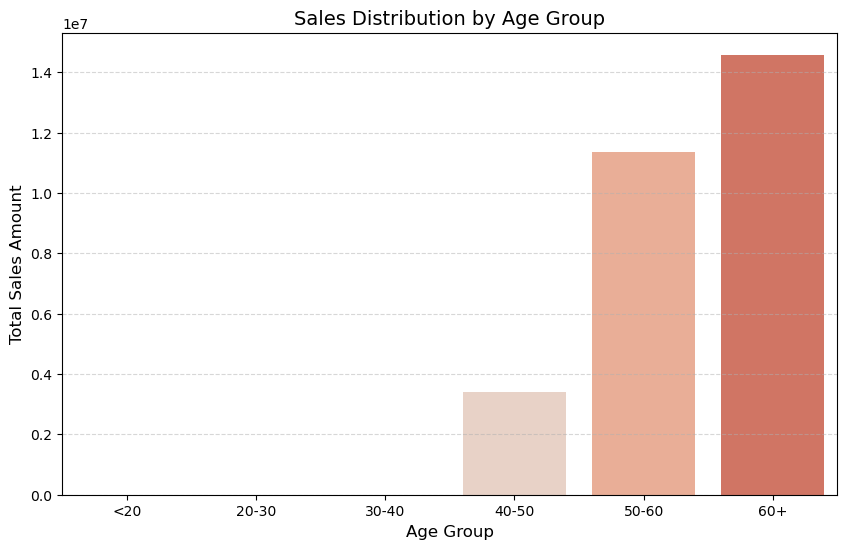

In [16]:
# Categorize age into bins
fact_complete_sales_pd = fact_complete_sales_visual.select(["Age", "SalesAmount"]).toPandas()
fact_complete_sales_pd["AgeGroup"] = pd.cut(
    fact_complete_sales_pd["Age"],
    bins=[0, 20, 30, 40, 50, 60, 100],  # Define age ranges
    labels=["<20", "20-30", "30-40", "40-50", "50-60", "60+"]
)

# Aggregate sales by AgeGroup
age_group_sales = fact_complete_sales_pd.groupby("AgeGroup")["SalesAmount"].sum().reset_index()

# Bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x="AgeGroup", y="SalesAmount", data=age_group_sales, palette="coolwarm")
plt.title("Sales Distribution by Age Group", fontsize=14)
plt.xlabel("Age Group", fontsize=12)
plt.ylabel("Total Sales Amount", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()


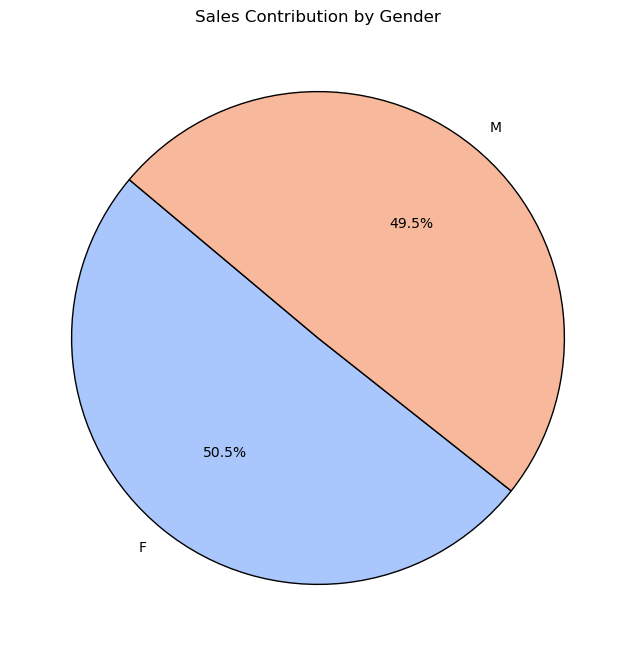

In [18]:
# Group by Gender and aggregate sales
gender_sales = fact_complete_sales_visual.groupBy("Gender") \
                                  .agg(F.sum("SalesAmount").alias("TotalSalesAmount")).toPandas()
# Pie chart
plt.figure(figsize=(8, 8))
colors = sns.color_palette('coolwarm', len(gender_sales))
plt.pie(gender_sales["TotalSalesAmount"], 
        labels=gender_sales["Gender"], 
        startangle=140, 
        colors=colors, 
        autopct='%1.1f%%', 
        wedgeprops={'edgecolor': 'black'})

plt.title("Sales Contribution by Gender")
plt.show()


C:\Users\anxhe\AppData\Local\Temp\ipykernel_26108\2851125522.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="NumberCarsOwned", y="TotalSalesAmount", data=cars_owned_sales, palette="viridis")


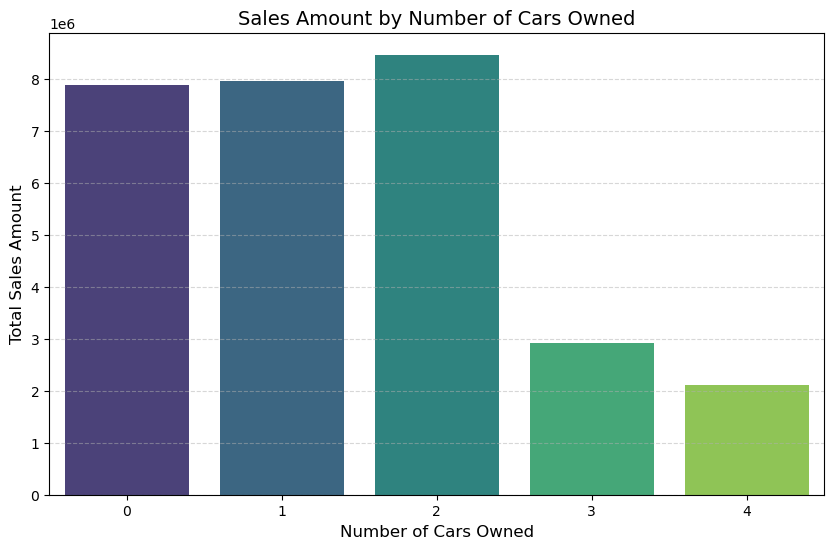

In [19]:
# Group by NumberCarsOwned
cars_owned_sales = fact_complete_sales_visual.groupBy("NumberCarsOwned") \
                                      .agg(F.sum("SalesAmount").alias("TotalSalesAmount")).toPandas()

# Bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x="NumberCarsOwned", y="TotalSalesAmount", data=cars_owned_sales, palette="viridis")
plt.title("Sales Amount by Number of Cars Owned", fontsize=14)
plt.xlabel("Number of Cars Owned", fontsize=12)
plt.ylabel("Total Sales Amount", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()

C:\Users\anxhe\AppData\Local\Temp\ipykernel_26108\271261935.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="MaritalStatus", y="TotalSalesAmount", data=marital_status_sales, palette="Blues_d")


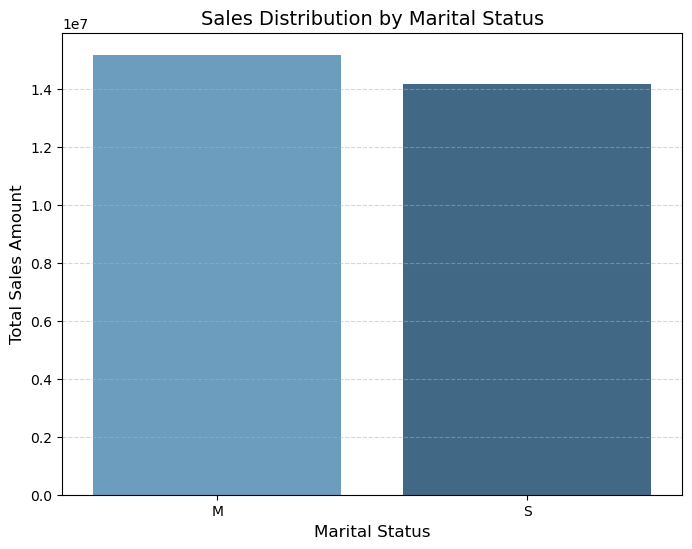

In [20]:
# Group by MaritalStatus_Encoded and sum SalesAmount
marital_status_sales = fact_complete_sales_visual.groupBy("MaritalStatus") \
                                          .agg(F.sum("SalesAmount").alias("TotalSalesAmount")).toPandas()
# Bar plot
plt.figure(figsize=(8, 6))
sns.barplot(x="MaritalStatus", y="TotalSalesAmount", data=marital_status_sales, palette="Blues_d")
plt.title("Sales Distribution by Marital Status", fontsize=14)
plt.xlabel("Marital Status", fontsize=12)
plt.ylabel("Total Sales Amount", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()

C:\Users\anxhe\AppData\Local\Temp\ipykernel_26108\2129648133.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="EnglishEducation", y="TotalSalesAmount", data=education_sales, palette="Pastel1")


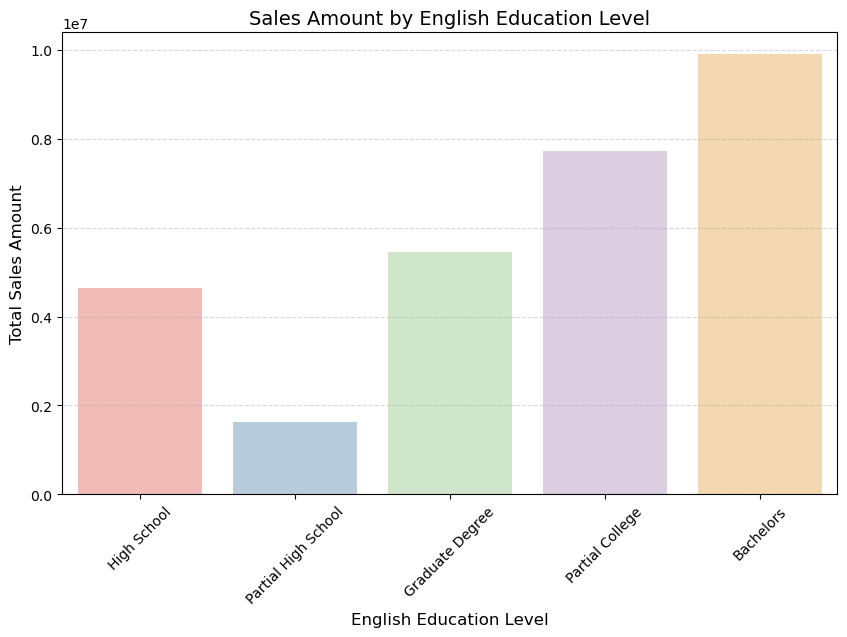

In [21]:
# Group by EnglishEducation_Encoded and sum SalesAmount
education_sales = fact_complete_sales_visual.groupBy("EnglishEducation") \
                                     .agg(F.sum("SalesAmount").alias("TotalSalesAmount")) \
                                     .toPandas()
# Bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x="EnglishEducation", y="TotalSalesAmount", data=education_sales, palette="Pastel1")
plt.title("Sales Amount by English Education Level", fontsize=14)
plt.xlabel("English Education Level", fontsize=12)
plt.ylabel("Total Sales Amount", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()

C:\Users\anxhe\AppData\Local\Temp\ipykernel_26108\2579302527.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="CommuteDistance", y="TotalSalesAmount", data=commute_sales, palette="coolwarm")


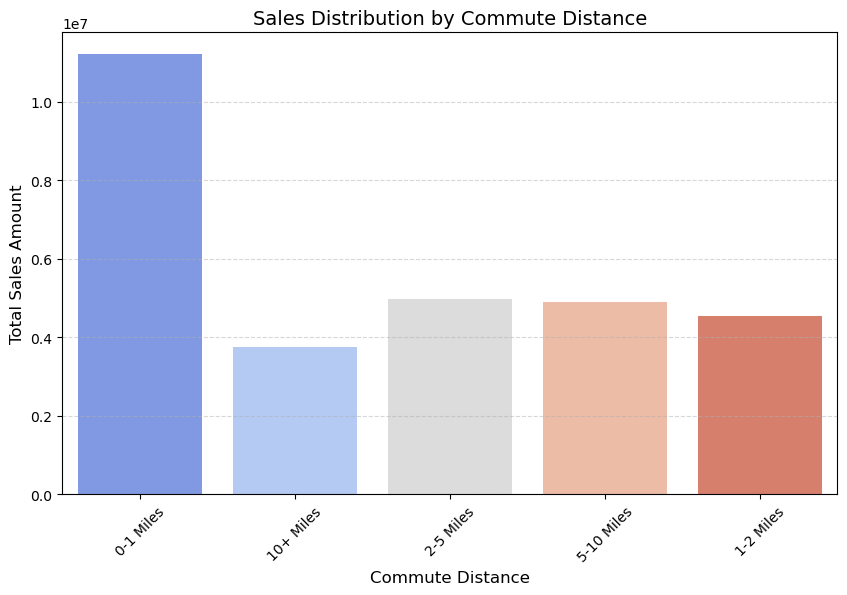

In [22]:
# Group by CommuteDistance_Encoded and sum SalesAmount
commute_sales = fact_complete_sales_visual.groupBy("CommuteDistance") \
                                   .agg(F.sum("SalesAmount").alias("TotalSalesAmount")) \
                                   .toPandas()
# Bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x="CommuteDistance", y="TotalSalesAmount", data=commute_sales, palette="coolwarm")
plt.title("Sales Distribution by Commute Distance", fontsize=14)
plt.xlabel("Commute Distance", fontsize=12)
plt.ylabel("Total Sales Amount", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()

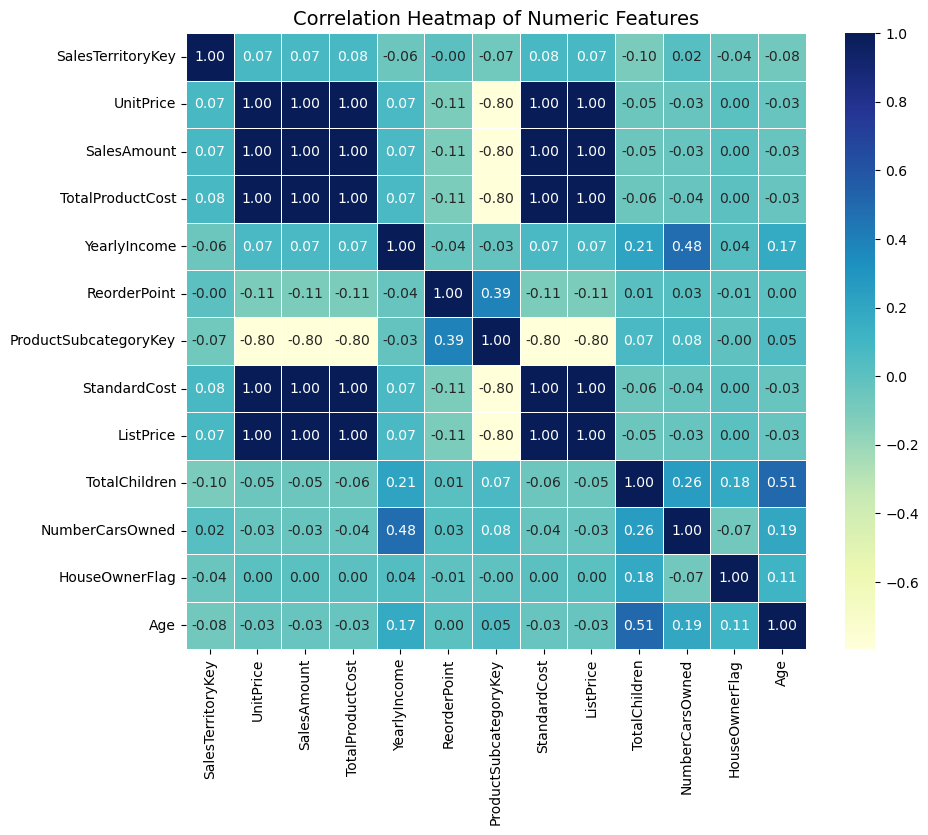

In [23]:
# Convert the required columns to Pandas for correlation calculation
numeric_columns = ["SalesTerritoryKey", "UnitPrice", "SalesAmount", "TotalProductCost", "YearlyIncome", 
                 "ReorderPoint", "ProductSubcategoryKey", "StandardCost", "ListPrice",  
                 "TotalChildren", "NumberCarsOwned", "HouseOwnerFlag", "Age"]
fact_complete_sales_pd = fact_complete_sales.select(numeric_columns).toPandas()

# Correlation matrix
correlation_matrix = fact_complete_sales_pd.corr()

# Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="YlGnBu", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of Numeric Features", fontsize=14)
plt.show()

In [25]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler

# Columns to index
categorical_columns = ['MaritalStatus', 'Gender', 'EnglishEducation', 'CommuteDistance', 
                       'EnglishOccupation', 'SalesTerritoryCountry']

# Index each categorical column
for column in categorical_columns:
    indexer = StringIndexer(inputCol=column, outputCol=f"{column}_indexed")
    fact_complete_sales = indexer.fit(fact_complete_sales).transform(fact_complete_sales)

# Feature columns to include
feature_columns = [
    'MaritalStatus_indexed', 'Gender_indexed', 'EnglishEducation_indexed', 
    'CommuteDistance_indexed', 'EnglishOccupation_indexed', 'SalesTerritoryCountry_indexed', 
    'Age', 'NumberCarsOwned', 'HouseOwnerFlag', 'TotalChildren', 'YearlyIncome', 
    'ProductKey', 'ProductSubcategoryKey', 'StandardCost', 'ListPrice', 'ReorderPoint', 
    'SalesTerritoryKey', 'UnitPrice', 'TotalProductCost'
]

# Assemble all features into a single vector column
assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')
fact_complete_sales = assembler.transform(fact_complete_sales)

# Convert to pandas DataFrame
fact_sales_pd = fact_complete_sales.select(*feature_columns, 'SalesAmount').toPandas()

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Define features (X) and target variable (y)
X = fact_sales_pd[feature_columns]
y = fact_sales_pd['SalesAmount']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [27]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Train the linear regression model
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

# Make predictions
y_pred = lin_reg.predict(X_test)

# Evaluate regression metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"R2 Score: {r2:.2f}")

# Create a DataFrame to compare actual vs predicted values
comparison_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred
})
# Display the DataFrame
print(comparison_df)

Mean Squared Error: 0.00
R2 Score: 1.00
        Actual  Predicted
19498  2319.99    2319.99
39862    53.99      53.99
35816   564.99     564.99
49518     8.99       8.99
35657     9.99       9.99
...        ...        ...
11028   769.49     769.49
32234     4.99       4.99
21069     9.99       9.99
30404     4.99       4.99
10746     4.99       4.99

[12080 rows x 2 columns]


In [28]:
from sklearn.tree import DecisionTreeRegressor

# Train the model
dt_regressor = DecisionTreeRegressor(random_state=42)
dt_regressor.fit(X_train, y_train)

# Predictions
y_pred_dt = dt_regressor.predict(X_test)

# Evaluation
mse_dt = mean_squared_error(y_test, y_pred_dt)
r2_dt = r2_score(y_test, y_pred_dt)

print(f'Mean Squared Error (Decision Tree): {mse_dt}')
print(f'R2 Score (Decision Tree): {r2_dt}')

# Create a DataFrame to compare actual vs predicted values
comparison_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred_dt
})
# Display the DataFrame
print(comparison_df)

Mean Squared Error (Decision Tree): 5.201332093458241e-23
R2 Score (Decision Tree): 1.0
        Actual  Predicted
19498  2319.99    2319.99
39862    53.99      53.99
35816   564.99     564.99
49518     8.99       8.99
35657     9.99       9.99
...        ...        ...
11028   769.49     769.49
32234     4.99       4.99
21069     9.99       9.99
30404     4.99       4.99
10746     4.99       4.99

[12080 rows x 2 columns]


In [29]:
from sklearn.ensemble import GradientBoostingRegressor

# Train the model
gbr = GradientBoostingRegressor(random_state=42)
gbr.fit(X_train, y_train)

# Predictions
y_pred_gbr = gbr.predict(X_test)

# Evaluation
mse_gbr = mean_squared_error(y_test, y_pred_gbr)
r2_gbr = r2_score(y_test, y_pred_gbr)

print(f'Mean Squared Error (Gradient Boosting): {mse_gbr}')
print(f'R2 Score (Gradient Boosting): {r2_gbr}')

# Create a DataFrame to compare actual vs predicted values
comparison_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred_dt
})
# Display the DataFrame
print(comparison_df)

Mean Squared Error (Gradient Boosting): 0.001295515126443518
R2 Score (Gradient Boosting): 0.999999998505367
        Actual  Predicted
19498  2319.99    2319.99
39862    53.99      53.99
35816   564.99     564.99
49518     8.99       8.99
35657     9.99       9.99
...        ...        ...
11028   769.49     769.49
32234     4.99       4.99
21069     9.99       9.99
30404     4.99       4.99
10746     4.99       4.99

[12080 rows x 2 columns]
